# Noise Decomposition Tutorial
We start with the setup/import statements that we will need. Note that we've set the logging level to INFO. This can be
changed to see more or less of the code's logging messages.

In [1]:
import logging
import matplotlib
import numpy as np
import mkidcalculator as mc
import matplotlib.pyplot as plt

%matplotlib inline
logging.basicConfig(level=logging.INFO)

Let's load in the data from the loop fitting tutorial but look at just one loop.

In [2]:
directory = '/Volumes/data/Paul/PtSi_MKIDs/Data/PtSi/20160219/ps2/'
file_name = 'sweep_config_20160219180719.mat'
sweep = mc.Sweep.from_file(directory + file_name, data=mc.io.legacy_sweep)
loop = sweep.resonators[0].loops[1]

All of the noise datasets taken for this resonator loop are stored inside of the loop's noise attribute.
Each noise object has a matrix of I and Q mixer data from which we can plot the first trace as a function of time.

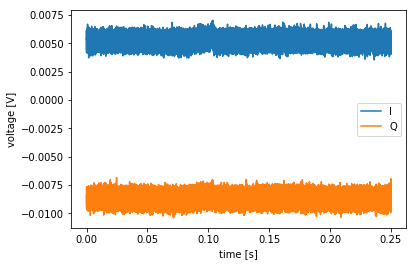

In [3]:
noise = loop.noise[0]
time = np.arange(noise.i_trace.shape[1]) / noise.sample_rate  # time in s
plt.plot(time, noise.i_trace[0], label="I")
plt.plot(time, noise.q_trace[0], label="Q")
plt.legend()
plt.xlabel("time [s]")
plt.ylabel("voltage [V]");

We can also plot the I and Q data on the resonance loop.

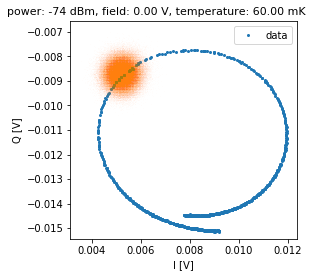

In [4]:
axes_list = loop.plot("iq", n_rows=1)
axes_list[0].plot(noise.i_trace[0], noise.q_trace[0], '.', markersize=0.01);

To translate the I and Q data to a phase and dissipation, we must apply a coordinate transformation which requires the
loop to be fit.
 
We do so just as in the loop fitting tutorial, and then choose the fit which we would like to use in the
compute_phase_and_dissipation() method. The phase can be unwrapped if needed.

INFO:mkidcalculator.experiments.loop_fitting:starting <function basic_fit at 0x1c1f5d68c8>
INFO:mkidcalculator.experiments.loop_fitting:loop 120799374360 fit: label = 'basic_fit', reduced chi squared = 67.6798
INFO:mkidcalculator.experiments.loop_fitting:starting iteration: 0
INFO:mkidcalculator.experiments.loop_fitting:starting <function temperature_fit at 0x1c1f5d69d8>
INFO:mkidcalculator.experiments.loop_fitting:starting <function power_fit at 0x1c1f5d6950>
INFO:mkidcalculator.experiments.loop_fitting:starting <function nonlinear_fit at 0x1c1f5d6ae8>
INFO:mkidcalculator.experiments.loop_fitting:loop 120799374360 fit: label = 'nonlinear_fit0', reduced chi squared = 7.04485
INFO:mkidcalculator.experiments.loop_fitting:starting <function linear_fit at 0x1c1f5d6a60>
INFO:mkidcalculator.experiments.loop_fitting:loop 120799374360 fit: label = 'linear_fit0', reduced chi squared = 67.6798
INFO:mkidcalculator.experiments.loop_fitting:starting iteration: 1
INFO:mkidcalculator.experiments.loop

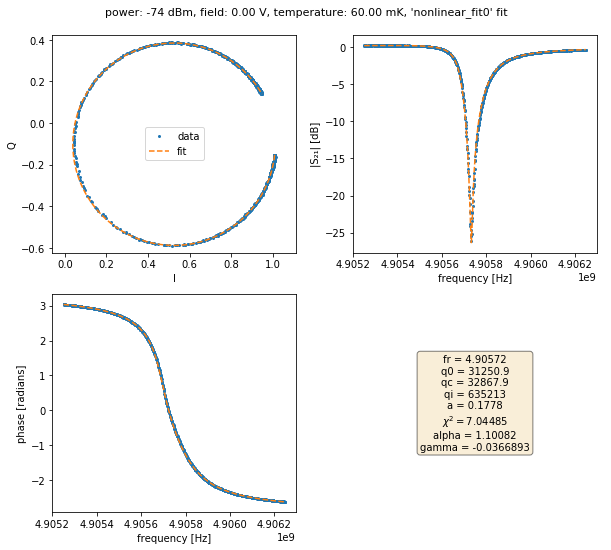

In [5]:
mc.experiments.multiple_fit(loop, guess_kwargs={'fit_imbalance': True})

loop.plot(
    plot_fit=True,
    calibrate=True, 
    fit_parameters=("fr", "q0", "qc", "qi", "a", "chi2", "alpha", "gamma")
)

noise.compute_phase_and_dissipation(label="best", unwrap=False);

The p_trace and d_trace attributes are now populated with the transformed data and are in units of radians. A phase of
zero corresponds to on resonance and a dissipation of zero corresponds to on the loop.

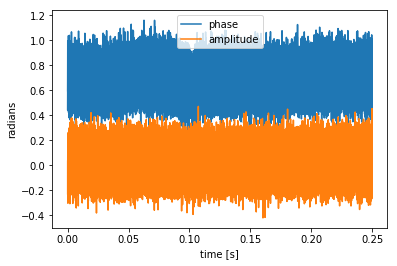

In [6]:
plt.plot(time, noise.p_trace[0], label="phase")
plt.plot(time, noise.d_trace[0], label="dissipation")
plt.legend()
plt.xlabel("time [s]")
plt.ylabel("radians");

We can also calculate the power spectral density of the noise from the trace data and plot it.

Under the hood this method used scipy.signal.welch, so we can use the nperseg keyword argument to select a shorter time
range and take advantage of averaging. 

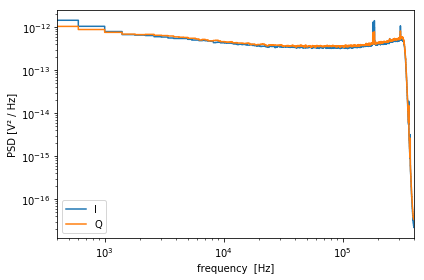

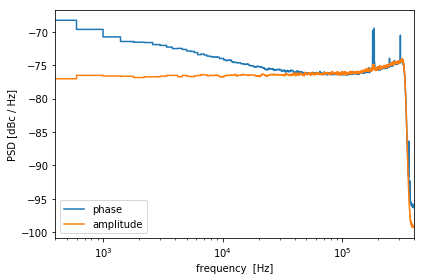

In [7]:
noise.compute_psd(nperseg=2000)
noise.plot_psd("iq")
noise.plot_psd("pd");

Note that after decomposing the noise into the phase and dissipation directions there is no 1/f dissipation noise at low 
frequencies.